In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

from scipy import stats

import ajf_plts
 
SEED = ajf_plts.get_seed('temp_to_freq_model.ipynb')

plt.style.use(['./ajf_plts/base.mplstyle',
               './ajf_plts/legend_frame.mplstyle'])

This code does the follow steps:
* Joins together the various MIDAS year files
* Converts the index to be half hourly to match the SSI freqs
* Interpolates the NaNs that are placed at the half hour positions

# Load MIDAS weather data

In [29]:
midas_df = (
    pd.concat(
        [
            pd.read_csv(
                f,
                engine="python",
                skiprows=280,
                skipfooter=1,
                usecols=["ob_time", "air_temperature"],
                parse_dates=["ob_time"],
                infer_datetime_format=True,
                index_col=["ob_time"],
            ).dropna()
            for f in glob.glob("midas-*.csv")
        ]
    )
    .asfreq("0.5H")
    
)

print(midas_df)
midas_df.describe()

                     air_temperature
ob_time                             
2018-01-01 00:00:00              3.9
2018-01-01 00:30:00              NaN
2018-01-01 01:00:00              3.8
2018-01-01 01:30:00              NaN
2018-01-01 02:00:00              4.1
...                              ...
2020-12-31 21:00:00              4.7
2020-12-31 21:30:00              NaN
2020-12-31 22:00:00              4.4
2020-12-31 22:30:00              NaN
2020-12-31 23:00:00              3.8

[52607 rows x 1 columns]


,air_temperature
count,26286.000000
mean,9.429084
std,4.928099
min,-4.100000
25%,5.800000
50%,9.100000
75%,12.900000
max,28.600000


## Fill in missing values

In [30]:
print(midas_df[midas_df.isna().values])

                     air_temperature
ob_time                             
2018-01-01 00:30:00              NaN
2018-01-01 01:30:00              NaN
2018-01-01 02:30:00              NaN
2018-01-01 03:30:00              NaN
2018-01-01 04:30:00              NaN
...                              ...
2020-12-31 18:30:00              NaN
2020-12-31 19:30:00              NaN
2020-12-31 20:30:00              NaN
2020-12-31 21:30:00              NaN
2020-12-31 22:30:00              NaN

[26321 rows x 1 columns]


In [31]:
midas_df = midas_df.interpolate().reset_index().rename(columns={'ob_time':'time'})
print(midas_df)

                     time  air_temperature
0     2018-01-01 00:00:00             3.90
1     2018-01-01 00:30:00             3.85
2     2018-01-01 01:00:00             3.80
3     2018-01-01 01:30:00             3.95
4     2018-01-01 02:00:00             4.10
...                   ...              ...
52602 2020-12-31 21:00:00             4.70
52603 2020-12-31 21:30:00             4.55
52604 2020-12-31 22:00:00             4.40
52605 2020-12-31 22:30:00             4.10
52606 2020-12-31 23:00:00             3.80

[52607 rows x 2 columns]


# Load in bridge frequency data

In [32]:
import scipy.io

mode_1_mat = scipy.io.loadmat("mode_1.mat")

time1 = pd.to_datetime(mode_1_mat["Time"].reshape(-1), unit="s")
freq1 = mode_1_mat["Frequency"].reshape(-1)
temp1 = mode_1_mat["TempT_0"].reshape(-1)

gh_df = pd.DataFrame({"time": time1, "freq": freq1}).sort_values(
    "time"
)
print(gh_df)
gh_df.describe()

                     time      freq
0     2018-10-19 06:17:06  5.707690
1     2018-10-19 06:47:06  5.705696
2     2018-10-19 07:17:06  5.713192
3     2018-10-19 07:47:06  5.689763
4     2018-10-19 08:17:06  5.675845
...                   ...       ...
18426 2021-03-30 04:47:20  5.693058
18427 2021-03-30 05:17:20  5.702516
18428 2021-03-30 05:47:21  5.684138
18429 2021-03-30 06:17:21  5.658545
18430 2021-03-30 06:47:21  5.679977

[18431 rows x 2 columns]


,freq
count,18431.000000
mean,5.683987
std,0.130653
min,5.003418
25%,5.594548
50%,5.708642
75%,5.766512
max,6.492711


In [33]:
df = (
    pd.merge_asof(
        left=midas_df,
        right=gh_df,
        on='time',
        tolerance=pd.Timedelta("1H"),
        direction="nearest",
    )
    .set_index("time")
)
full_df = df.copy()
print(df)

                     air_temperature  freq
time                                      
2018-01-01 00:00:00             3.90   NaN
2018-01-01 00:30:00             3.85   NaN
2018-01-01 01:00:00             3.80   NaN
2018-01-01 01:30:00             3.95   NaN
2018-01-01 02:00:00             4.10   NaN
...                              ...   ...
2020-12-31 21:00:00             4.70   NaN
2020-12-31 21:30:00             4.55   NaN
2020-12-31 22:00:00             4.40   NaN
2020-12-31 22:30:00             4.10   NaN
2020-12-31 23:00:00             3.80   NaN

[52607 rows x 2 columns]


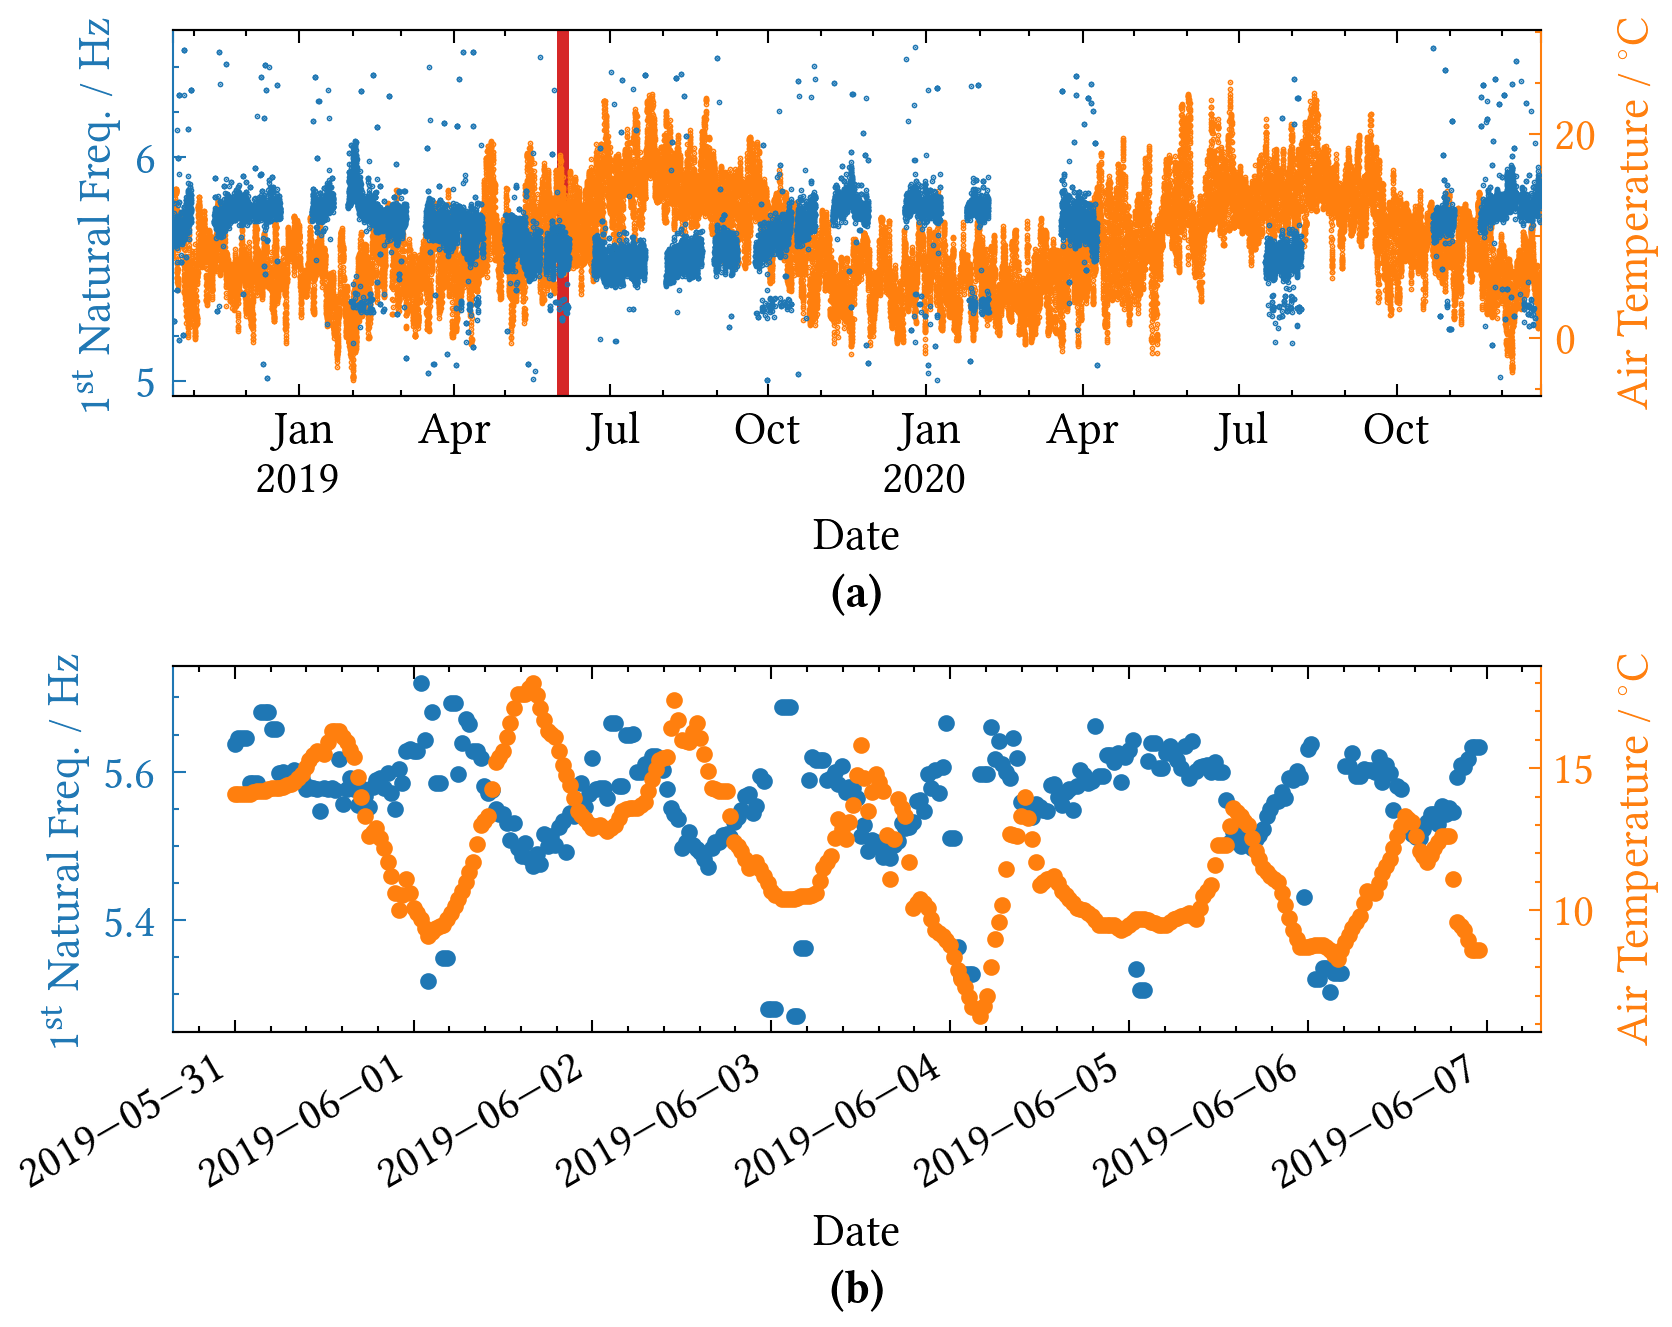

In [38]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, 2.0*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=2)

freq_vals = df.freq.dropna()

ax2 = axes[0].twinx()

axes[0].yaxis.tick_right()
axes[0].yaxis.set_label_position("right")
df.air_temperature.plot(ax=axes[0], ls='', c='C1', marker='.', markersize=0.75, rasterized=True)

ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
df.freq.plot(ax=ax2, ls='', c='C0', marker='.', markersize=0.75, rasterized=True)

axes[0].set_xlim([min(df.dropna().index), max(df.dropna().index)])

start_date = '2019-5-31'
end_date = '2019-6-7'

ax3 = axes[1].twinx()
mask = (df.index >= start_date) & (df.index <= end_date)
df[mask].dropna().freq.plot(ax=axes[1], ls='', c='C0', marker='.')
df[mask].dropna().air_temperature.plot(ax=ax3, ls='', c='C1', marker='.')

axes[0].axvspan(start_date, end_date, fc='C3')

for ax in axes:
    ax.set_xlabel('Date')
    
for ax in [ax2, axes[1]]:
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}', c='C0')
    ax.tick_params(axis='y', which='both', colors='C0')
    ax.spines['left'].set_color('C0')
    ax.spines['right'].set_visible(False)
    
for ax in [axes[0], ax3]:
    ax.set_ylabel(r'Air Temperature / \unit{\celsius}', c='C1')
    ax.tick_params(axis='y', which='both', colors='C1')
    ax.spines['right'].set_color('C1')
    ax.spines['left'].set_visible(False)

ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, 'figRawFirstFrequenciesTemps.pdf')

## Find outliers

In [35]:
def median_absolute_deviation(x):
    """
    Returns the median absolute deviation from the window's median
    :param x: Values in the window
    :return: MAD
    """
    return np.median(np.abs(x - np.median(x)))


def hampel(ts, window_size=5, n=3, imputation=False):

    """
    Median absolute deviation (MAD) outlier in Time Series
    :param ts: a pandas Series object representing the timeseries
    :param window_size: total window size will be computed as 2*window_size + 1
    :param n: threshold, default is 3 (Pearson's rule)
    :param imputation: If set to False, then the algorithm will be used for outlier detection.
        If set to True, then the algorithm will also imput the outliers with the rolling median.
    :return: Returns the outlier indices if imputation=False and the corrected timeseries if imputation=True
    """

    if type(ts) != pd.Series:
        raise ValueError("Timeserie object must be of tyme pandas.Series.")

#    if type(window_size) == int:
#        raise ValueError("Window size must be of type integer.")
#    else:
#        if window_size <= 0:
#            raise ValueError("Window size must be more than 0.")
#
#     if type(n) != int:
#         raise ValueError("Window size must be of type integer.")
#     else:
#         if n < 0:
#             raise ValueError("Window size must be equal or more than 0.")

    # Copy the Series object. This will be the cleaned timeserie
    ts_cleaned = ts.copy()

    # Constant scale factor, which depends on the distribution
    # In this case, we assume normal distribution
    rolling_ts = ts_cleaned.rolling(window_size, min_periods=1, center=True)
    rolling_median = rolling_ts.median().fillna(method='bfill').fillna(method='ffill')
    rolling_mad = (rolling_ts.apply(median_absolute_deviation).fillna(method='bfill').fillna(method='ffill'))

    outlier_indices = list(
        np.array(np.where(np.abs(ts_cleaned - rolling_median) >= (n * rolling_mad))).flatten())

    if imputation:
        ts_cleaned[outlier_indices] = rolling_median[outlier_indices]
        return ts_cleaned

    return outlier_indices

In [14]:
#full_df=df.copy()
df=full_df.copy()
outliers = hampel(ts=df.freq, window_size=int(24), n=3.0)
df.freq.iloc[outliers] = np.nan

print(len(outliers))

1678


## Check outliers are at night

In [419]:
len(df)

26304

In [420]:
outlier_hours = df.index[outliers].hour

day_hours = np.arange(7, 19)

day_outliers = outlier_hours.isin(day_hours).sum()
night_outliers = (~(outlier_hours.isin(day_hours))).sum()

print(f'Total outliers: N={len(outliers)} ({len(outliers)/len(df):2.2%})')
print(f'Day outliers:   N={day_outliers} ({day_outliers/len(df):2.2%})')
print(f'Night outliers: N={night_outliers} ({night_outliers/len(df):2.2%})')

Total outliers: N=900 (3.42%)
Day outliers:   N=133 (0.51%)
Night outliers: N=767 (2.92%)


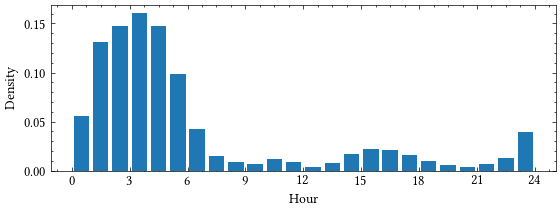

In [421]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)
outlier_hours.to_series().plot(kind='hist', density=True, rwidth=0.8, bins=np.arange(25))
ax.set_xlabel('Hour')
ax.set_xticks(np.arange(25)[::3])
ax.set_ylabel('Density')
fig.tight_layout()
ajf_plts.save_fig(fig, 'figOutlierTimes.pdf')

## Interpolate gaps

In [422]:
df = df.interpolate(method='linear', limit=6, limit_area='inside')
interpolated = (~(df.freq.eq(full_df.freq) | (df.freq.isna() & full_df.freq.isna())))

## Plot

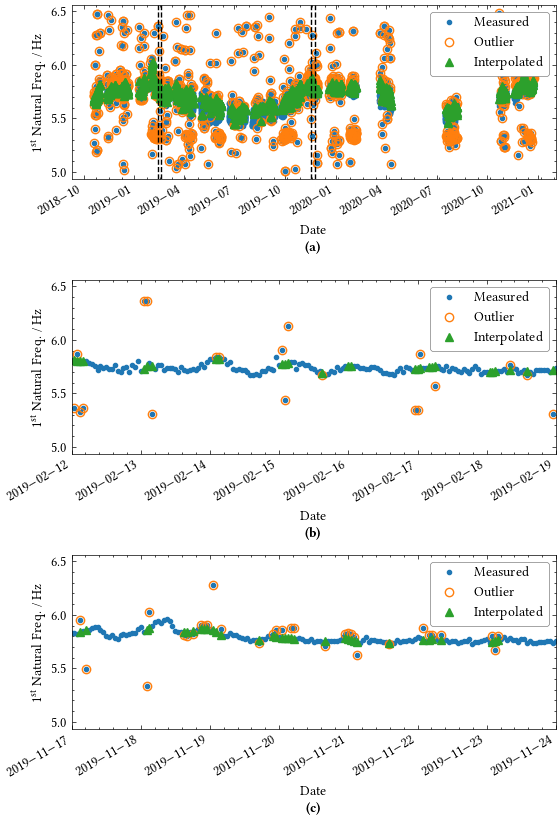

In [423]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.text_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=3)
axes=axes.ravel()

for ax in axes:
    full_df.freq.dropna().plot(ax=ax, ls='', marker='.', label='Measured', rasterized=True)
    full_df.freq[outliers].plot(ax=ax, ls='', marker='o', markerfacecolor='none', label='Outlier', rasterized=True)
    df.freq[interpolated].plot(ax=ax, ls='', marker='^', label='Interpolated', rasterized=True)
    ax.set_xlabel('Date')
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
    ax.legend(loc='upper right')
    
axes[1].set_xlim((pd.Timestamp('2019-02-12'), pd.Timestamp('2019-02-19')))
axes[0].axvline(pd.Timestamp('2019-02-12'), c='k', ls='--')
axes[0].axvline(pd.Timestamp('2019-02-19'), c='k', ls='--')
    
axes[2].set_xlim((pd.Timestamp('2019-11-17'), pd.Timestamp('2019-11-24')))
axes[0].axvline(pd.Timestamp('2019-11-17'), c='k', ls='--')
axes[0].axvline(pd.Timestamp('2019-11-24'), c='k', ls='--')

ajf_plts.caption_axes(axes)
fig.tight_layout()

ajf_plts.save_fig(fig, 'figFreqOutlierInterp.pdf')

# test train split

In [424]:
all_df = df.dropna()

n_points = len(all_df)
train_prop = 0.6
split_ind = int(n_points * train_prop)

train_df = all_df.iloc[:split_ind]
test_df = all_df.iloc[split_ind:]

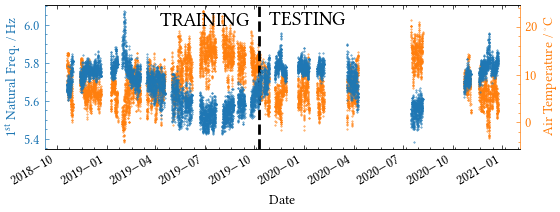

In [425]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize, ncols=1, nrows=1)

freq_vals = df.freq.dropna()

ax2 = ax.twinx()

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
all_df.air_temperature.plot(ax=ax, ls='', c='C1', marker='.', markersize=0.75, rasterized=True)

ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
all_df.freq.plot(ax=ax2, ls='', c='C0', marker='.', markersize=0.75, rasterized=True)

vl = ax.axvline(all_df.index.values[split_ind], ls='--', c='k', lw='2.0')
vl_x_ax = ax.transAxes.inverted().transform(ax.transData.transform(vl.get_xydata()[0]))[0]
ax.annotate('TRAINING',
        xy=(0.95*vl_x_ax, 0.95),
        xycoords='axes fraction',
        ha='right',
        va='top',
        fontsize=14.0,
        fontweight='bold')
ax.annotate('TESTING',
             xy=(1.05*vl_x_ax, 0.95),
             xycoords='axes fraction',
             ha='left',
             va='top',
             fontsize=14.0,
             fontweight='bold')

ax.set_xlabel('Date')
    
ax2.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}', c='C0')
ax2.tick_params(axis='y', which='both', colors='C0')
ax2.spines['left'].set_color('C0')
ax2.spines['right'].set_visible(False)
    
ax.set_ylabel(r'Air Temperature / \unit{\celsius}', c='C1')
ax.tick_params(axis='y', which='both', colors='C1')
ax.spines['right'].set_color('C1')
ax.spines['left'].set_visible(False)

fig.tight_layout()
ajf_plts.save_fig(fig, 'figTrainTestSplit.pdf')

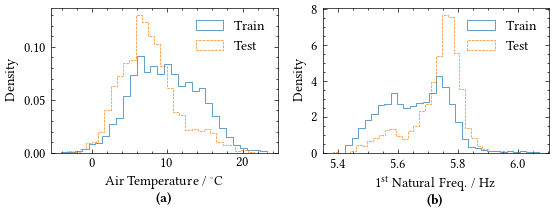

In [426]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2, nrows=1)

axes = axes.ravel()

ax_props = dict(kind='hist', bins=30, density=True, histtype='step', label='Train')

train_df.air_temperature.plot(ax=axes[0], **ax_props)
train_df.freq.plot(ax=axes[1], **ax_props)

ax_props['label'] = 'Test'

test_df.air_temperature.plot(ax=axes[0], **ax_props)
test_df.freq.plot(ax=axes[1], **ax_props)

axes[0].set_xlabel(r'Air Temperature / \unit{\celsius}')
axes[1].set_xlabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
for ax in axes:
    ax.set_ylabel('Density')
    ax.legend(edgecolor='None')
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

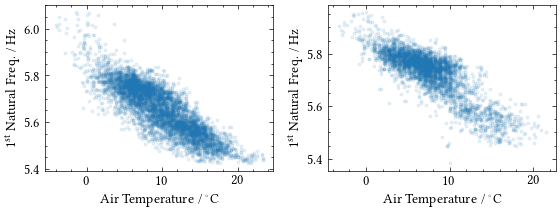

In [427]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2, nrows=1)

axes = axes.ravel()

ax_props = dict(kind='scatter', marker='.', alpha=0.1)

train_df.plot(ax=axes[0], x='air_temperature', y='freq', **ax_props)

test_df.plot(ax=axes[1], x='air_temperature', y='freq', **ax_props)

for ax in axes:
    ax.set_xlabel(r'Air Temperature / \unit{\celsius}')
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')

fig.tight_layout()

# fit AR model to Air temperature

In [428]:
import statsmodels as sm

timestamps = train_df.index
x = train_df.air_temperature.values.reshape(-1,1)
y = train_df.freq.values

## check for stationarity

In [429]:
alpha = 0.05

adf_res = sm.tsa.stattools.adfuller(x)
kpss_res = sm.tsa.stattools.kpss(x)
print(f"ADF p-value={adf_res[1]:1.3f} means {'stationary' if adf_res[1] < alpha else 'non-stationary'}")
print(f"KPSS p-value={kpss_res[1]:1.3f} means {'stationary' if kpss_res[1] > alpha else 'non-stationary'}")

ADF p-value=0.001 means stationary
KPSS p-value=0.010 means non-stationary


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [430]:
xdiff = sm.tsa.statespace.tools.diff(x)
ydiff = sm.tsa.statespace.tools.diff(y)
adf_res = sm.tsa.stattools.adfuller(xdiff)
kpss_res = sm.tsa.stattools.kpss(xdiff)
print(f"ADF p-value={adf_res[1]:1.3f} means {'stationary' if adf_res[1] < alpha else 'non-stationary'}")
print(f"KPSS p-value={kpss_res[1]:1.3f} means {'stationary' if kpss_res[1] > alpha else 'non-stationary'}")

ADF p-value=0.000 means stationary
KPSS p-value=0.100 means stationary


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## fit AR model to the exogenous variable

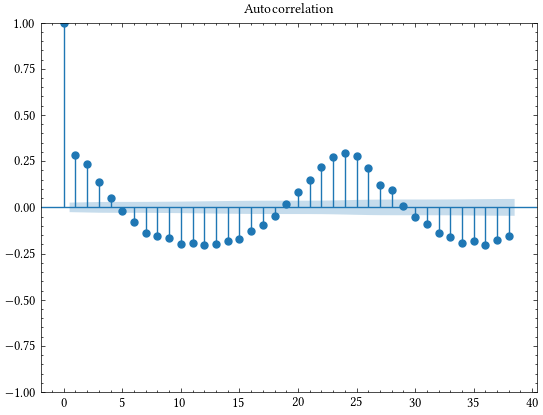

In [481]:
_ = sm.graphics.tsaplots.plot_acf(xdiff)

/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


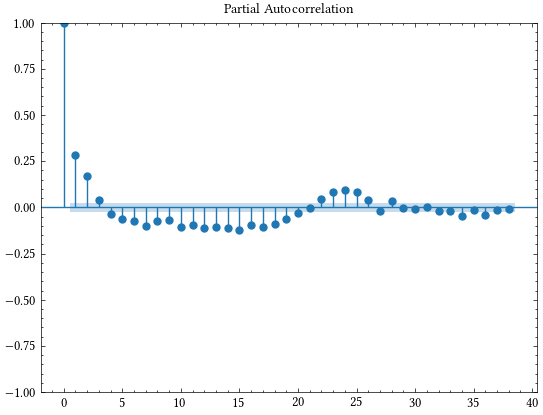

In [432]:
_ = sm.graphics.tsaplots.plot_pacf(xdiff)

In [482]:
model = sm.tsa.arima.model.ARIMA(endog=xdiff,
                                 order=(3,0,4),
                                 trend='n').fit()
model.summary()

/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5767
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -6448.189
Date:                Wed, 10 Aug 2022   AIC                          12912.377
Time:                        23:38:27   BIC                          12965.657
Sample:                             0   HQIC                         12930.917
                               - 5767                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9249      0.007    135.158      0.000       0.911       0.938
ar.L2          0.9262      0.013     71.962      0.000       0.901       0.951
ar.L3         -0.9863      0.007   -137.684      0.000      -1.000      -0.972
ma.L1         -0.8218      0.012    -70.002      0.000      -0.845      -0.799
ma.L2         -0.9859      0.016    -63.101      0.000      -1.017      -0.955
ma.L3          0.8737      0.012     70.027      0.000       0.849       0.898
ma.L4          0.0533      0.010      5.336      0.000       0.034       0.073
sigma2         0.5467      0.005    110.994      0.000       0.537       0.556
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14455.39
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

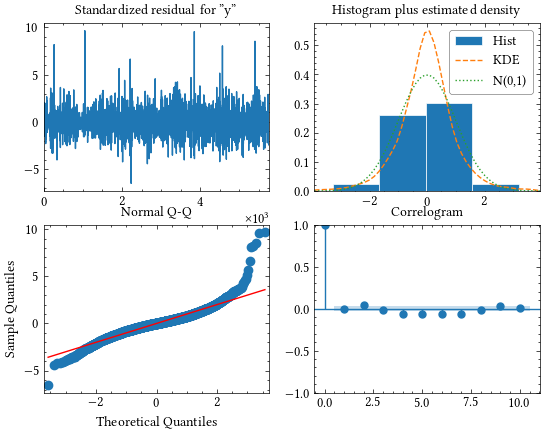

In [483]:
_=model.plot_diagnostics()

## pre-whiten the endog input

In [484]:
tmp = sm.tsa.filters.filtertools.recursive_filter(xdiff, -model.polynomial_reduced_ma[1:])
filt_exog = sm.tsa.filters.filtertools.convolution_filter(tmp, model.polynomial_reduced_ar, nsides=1)

tmp = sm.tsa.filters.filtertools.recursive_filter(ydiff, -model.polynomial_reduced_ma[1:])
filt_endog = sm.tsa.filters.filtertools.convolution_filter(tmp, model.polynomial_reduced_ar, nsides=1)

filt_exog = filt_exog[~np.isnan(filt_exog)]
filt_endog = filt_endog[~np.isnan(filt_endog)]

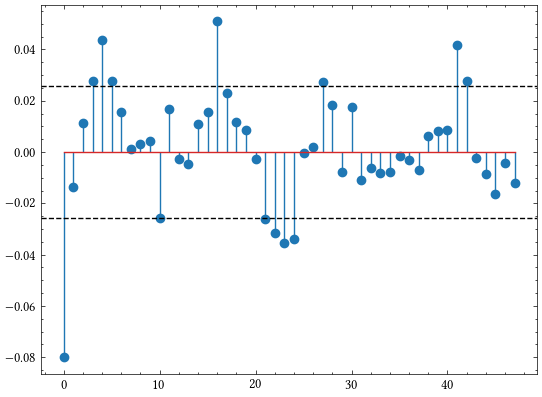

In [485]:
ccf = sm.api.tsa.ccf(filt_exog, filt_endog)

fig, ax = plt.subplots()
plt.stem(ccf[:48])
plt.axhline(-1.96/np.sqrt(len(filt_exog)), color='k', ls='--')
plt.axhline(1.96/np.sqrt(len(filt_exog)), color='k', ls='--')

# remove seasonal trend

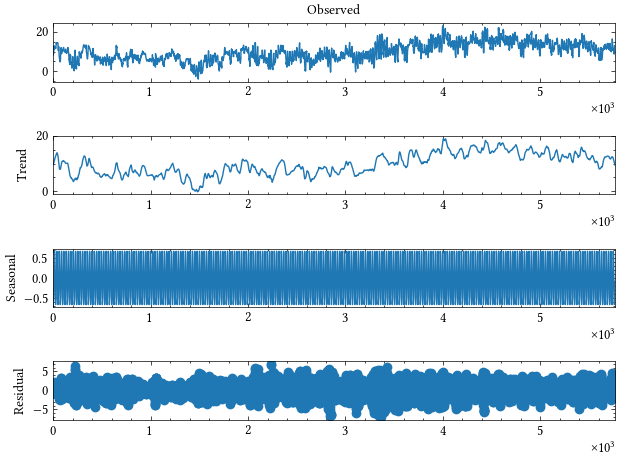

In [885]:
x_decomp = sm.tsa.seasonal.seasonal_decompose(x, period=24, extrapolate_trend=True)
_=x_decomp.plot()

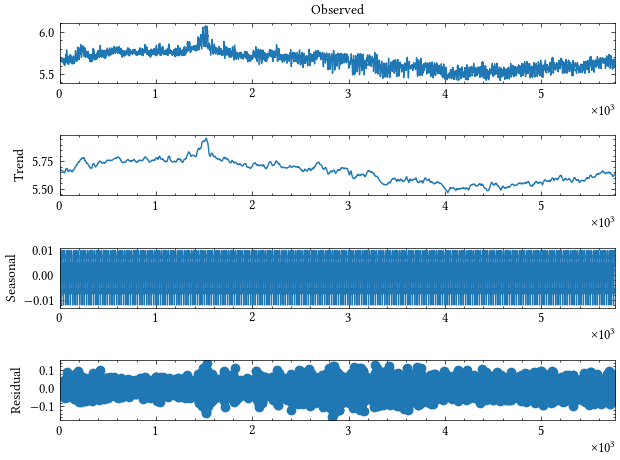

In [888]:
y_decomp = sm.tsa.seasonal.seasonal_decompose(y, period=24, extrapolate_trend=True)
_= y_decomp.plot()

In [923]:
x_test_decomp = sm.tsa.seasonal.seasonal_decompose(x_test, period=24, extrapolate_trend=True)
y_test_decomp = sm.tsa.seasonal.seasonal_decompose(y_test, period=24, extrapolate_trend=True)

# check for stationarity

In [899]:
def ajf_check_stationarity(series, alpha = 0.05):
    adf_res = sm.tsa.stattools.adfuller(series)
    kpss_res = sm.tsa.stattools.kpss(series)
    print(f"ADF p-value={adf_res[1]:1.3f} means {'stationary' if adf_res[1] < alpha else 'non-stationary'}")
    print(f"KPSS p-value={kpss_res[1]:1.3f} means {'stationary' if kpss_res[1] > alpha else 'non-stationary'}")

## trend

In [899]:
print('x-trend')
ajf_check_stationarity(x_decomp.trend)
print()
print('diff 1 x-trend')
ajf_check_stationarity(sm.tsa.statespace.tools.diff(x_decomp.trend))
print()
print('y-trend')
ajf_check_stationarity(y_decomp.trend)
print()
print('diff 1 y-trend')
ajf_check_stationarity(sm.tsa.statespace.tools.diff(y_decomp.trend))

x-trend
ADF p-value=0.006 means stationary
KPSS p-value=0.010 means non-stationary

diff 1 x-trend
ADF p-value=0.000 means stationary
KPSS p-value=0.100 means stationary

y-trend


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


ADF p-value=0.461 means non-stationary
KPSS p-value=0.010 means non-stationary

diff 1 y-trend
ADF p-value=0.000 means stationary
KPSS p-value=0.100 means stationary


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### seasonal

In [902]:
print('x-seasonal')
ajf_check_stationarity(x_decomp.seasonal)
print()
print('y-seasonal')
ajf_check_stationarity(y_decomp.seasonal)

x-seasonal
ADF p-value=0.000 means stationary
KPSS p-value=0.100 means stationary

y-seasonal
ADF p-value=0.000 means stationary
KPSS p-value=0.100 means stationary


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### residual

In [903]:
print('x-resid')
ajf_check_stationarity(x_decomp.resid)
print()
print('y-resid')
ajf_check_stationarity(y_decomp.resid)

x-resid
ADF p-value=0.000 means stationary
KPSS p-value=0.100 means stationary

y-resid
ADF p-value=0.000 means stationary
KPSS p-value=0.100 means stationary


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [891]:
adf_res = sm.tsa.stattools.adfuller(x_decomp.trend)
kpss_res = sm.tsa.stattools.kpss(x_decomp.trend)
print(f"ADF p-value={adf_res[1]:1.3f} means {'stationary' if adf_res[1] < alpha else 'non-stationary'}")
print(f"KPSS p-value={kpss_res[1]:1.3f} means {'stationary' if kpss_res[1] > alpha else 'non-stationary'}")

ADF p-value=0.006 means stationary
KPSS p-value=0.010 means non-stationary


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [892]:
xdiff = sm.tsa.statespace.tools.diff(x_decomp.trend)
ydiff = sm.tsa.statespace.tools.diff(y_decomp.trend)
adf_res = sm.tsa.stattools.adfuller(xdiff)
kpss_res = sm.tsa.stattools.kpss(xdiff)
print(f"ADF p-value={adf_res[1]:1.3f} means {'stationary' if adf_res[1] < alpha else 'non-stationary'}")
print(f"KPSS p-value={kpss_res[1]:1.3f} means {'stationary' if kpss_res[1] > alpha else 'non-stationary'}")

ADF p-value=0.000 means stationary
KPSS p-value=0.100 means stationary


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# fit ARDL model

In [860]:
from statsmodels.tsa.api import ARDL, ardl_select_order 
import statsmodels as sm
import statsmodels.tsa.api as tsa
from scipy import signal

## Trend

In [1073]:
exog = sm.tsa.statespace.tools.diff((x_decomp.trend).reshape(-1,1))
endog = sm.tsa.statespace.tools.diff(y_decomp.trend)

exog_test = sm.tsa.statespace.tools.diff(x_test_decomp.trend)
endog_test = sm.tsa.statespace.tools.diff(y_test_decomp.trend)

order = sm.api.tsa.ardl_select_order(endog=endog,
                                     exog=exog,
                                     maxlag=0,
                                     maxorder=0,
                                     causal=False,
                                     trend='n')

In [1074]:
order.ar_lags, order.dl_lags

(None, {0: [0]})

In [1075]:
model = sm.api.tsa.ARDL(endog=endog,
             exog=exog,
             lags=order.ar_lags,
             order=order.dl_lags,
             trend='n').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5767
Model:                     ARDL(0, 0)   Log Likelihood               29664.100
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Thu, 11 Aug 2022   AIC                         -59324.200
Time:                        00:52:19   BIC                         -59310.880
Sample:                             0   HQIC                        -59319.565
                                 5767                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x0.L0         -0.0062      0.000    -34.442      0.000      -0.007      -0.006
==============================================================================
"""

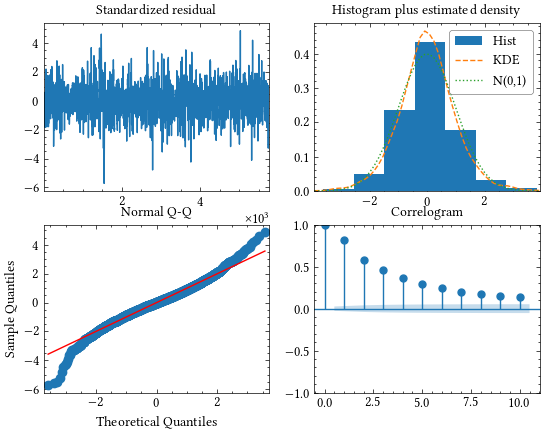

In [1068]:
_=model.plot_diagnostics()

In [1069]:
train_preds = model.forecast(steps=len(exog), exog=exog)
test_preds = model.forecast(steps=len(exog_test), exog=exog_test)

In [1070]:
from sklearn.metrics import mean_squared_error
print("Train RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(endog, train_preds))))
print("Test RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(endog_test, test_preds))))

Train RMSE: 0.001 Hz
Test RMSE: 0.001 Hz


In [1071]:
train_res = endog - train_preds
test_res = endog_test - test_preds 

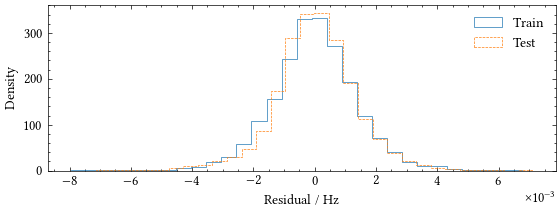

In [1072]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

ax_props = dict(bins=30, density=True, histtype='step')

ax.hist(train_res, **ax_props, label='Train')
ax.hist(test_res, **ax_props, label='Test')

ax.set_xlabel(r'Air Temperature / \unit{\celsius}')
ax.set_xlabel(r'Residual / \unit{\hertz}')
ax.set_ylabel('Density')
ax.legend(edgecolor='None')
    
fig.tight_layout()

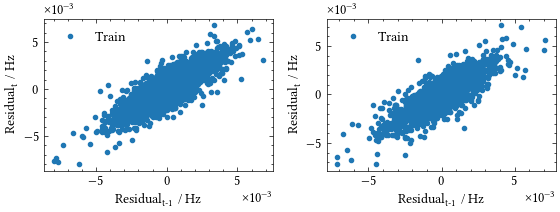

In [1063]:
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=1, ncols=2)

ax_props = dict(ls='', marker='.')

axes[0].plot(train_res[:-1], train_res[1:], **ax_props, label='Train')
axes[1].plot(test_res[:-1], test_res[1:], **ax_props, label='Train')

for ax in axes:
    ax.set_xlabel(r'Residual\textsubscript{t-1} / \unit{\hertz}')
    ax.set_ylabel(r'Residual\textsubscript{t} / \unit{\hertz}')
    ax.legend(edgecolor='None')
    
fig.tight_layout()

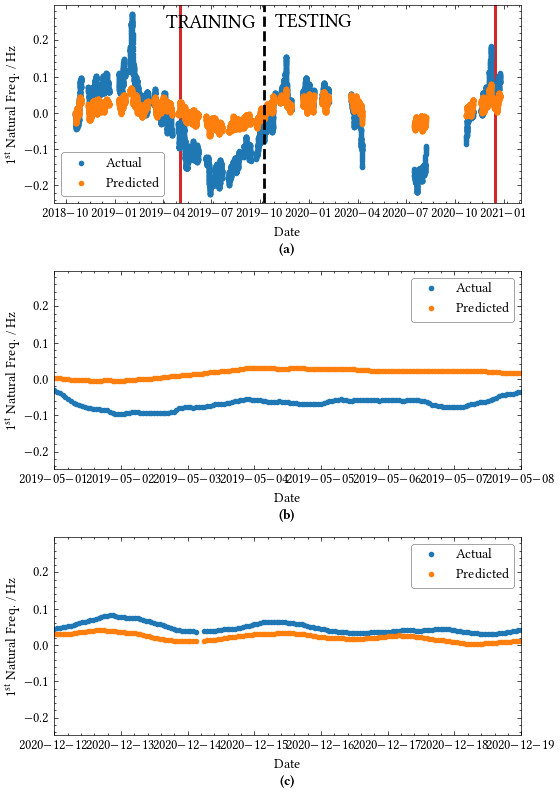

In [1064]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, 3.5*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=3)

axes = axes.ravel()

props = dict(ls='', marker='.')

for ax in axes:
    ax.plot(np.concatenate([train_df.index[1:], test_df.index[1:]]), np.cumsum(np.concatenate([endog, endog_test])),  **props, label='Actual')
    ax.plot(np.concatenate([train_df.index[1:], test_df.index[1:]]), np.cumsum(np.concatenate([train_preds, test_preds])),  **props, label='Predicted')
    
vl = axes[0].axvline(all_df.index.values[split_ind], ls='--', c='k', lw='2.0')
vl_x_ax = axes[0].transAxes.inverted().transform(axes[0].transData.transform(vl.get_xydata()[0]))[0]
axes[0].annotate('TRAINING',
        xy=(0.95*vl_x_ax, 0.95),
        xycoords='axes fraction',
        ha='right',
        va='top',
        fontsize=14.0,
        fontweight='bold')
axes[0].annotate('TESTING',
             xy=(1.05*vl_x_ax, 0.95),
             xycoords='axes fraction',
             ha='left',
             va='top',
             fontsize=14.0,
             fontweight='bold')

train_start = pd.to_datetime('2019-5-1')
train_end = pd.to_datetime('2019-5-8')

axes[0].axvspan(train_start, train_end, fc='C3')
axes[1].set_xlim([train_start, train_end])

test_start = pd.to_datetime('2020-12-12')
test_end = pd.to_datetime('2020-12-19')

axes[0].axvspan(test_start, test_end, fc='C3')
axes[2].set_xlim([test_start, test_end])

for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
    ax.legend()
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

## Seasonal + Residual

In [995]:
exog = (x_decomp.seasonal + x_decomp.resid).reshape(-1,1)
endog = y_decomp.seasonal + y_decomp.resid

exog_test = (x_test_decomp.seasonal + x_test_decomp.resid).reshape(-1,1)
endog_test = y_test_decomp.seasonal + y_test_decomp.resid

order = sm.api.tsa.ardl_select_order(endog=endog,
                          exog=exog,
                          maxlag=2,
                          maxorder=1,
                          causal=False,
                          trend='n',
                         )

In [996]:
order.ar_lags, order.dl_lags

([1, 2], {0: [0, 1]})

In [997]:
model = sm.api.tsa.ARDL(endog=endog,
             exog=exog,
             lags=order.ar_lags,
             order=order.dl_lags,
             trend='n').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5768
Model:                     ARDL(2, 1)   Log Likelihood               13810.679
Method:               Conditional MLE   S.D. of innovations              0.022
Date:                Thu, 11 Aug 2022   AIC                         -27611.359
Time:                        00:47:15   BIC                         -27578.060
Sample:                             2   HQIC                        -27599.772
                                 5768                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.4300      0.013     32.906      0.000       0.404       0.456
y.L2           0.0946      0.012      7.943      0.000       0.071       0.118
x0.L0         -0.0065      0.000    -17.691      0.000      -0.007      -0.006
x0.L1         -0.0020      0.000     -4.846      0.000      -0.003      -0.001
==============================================================================
"""

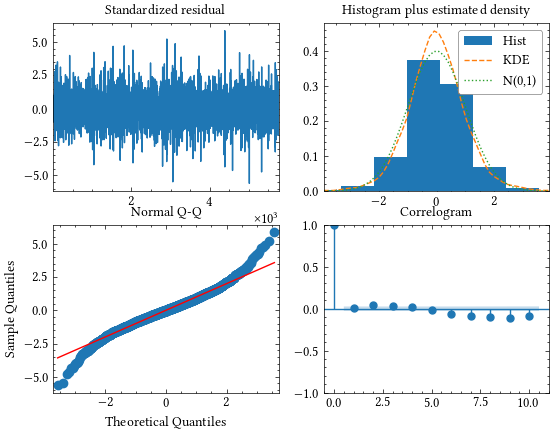

In [998]:
_=model.plot_diagnostics()

In [999]:
train_preds = model.forecast(steps=len(exog), exog=exog)
test_preds = model.forecast(steps=len(exog_test), exog=exog_test)

In [1003]:
from sklearn.metrics import mean_squared_error
print("Train RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(endog, train_preds))))
print("Test RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(endog_test, test_preds))))

Train RMSE: 0.025 Hz
Test RMSE: 0.025 Hz


In [1004]:
train_res = endog - train_preds
test_res = endog_test - test_preds 

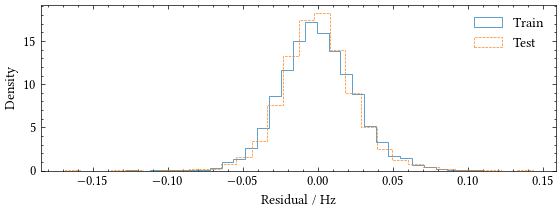

In [1005]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

ax_props = dict(bins=30, density=True, histtype='step')

ax.hist(train_res, **ax_props, label='Train')
ax.hist(test_res, **ax_props, label='Test')

ax.set_xlabel(r'Air Temperature / \unit{\celsius}')
ax.set_xlabel(r'Residual / \unit{\hertz}')
ax.set_ylabel('Density')
ax.legend(edgecolor='None')
    
fig.tight_layout()

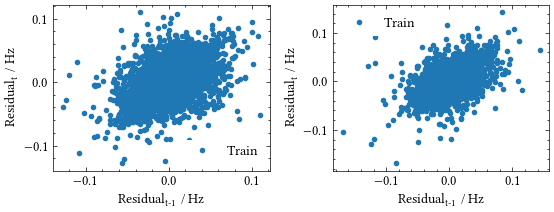

In [1006]:
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=1, ncols=2)

ax_props = dict(ls='', marker='.')

axes[0].plot(train_res[:-1], train_res[1:], **ax_props, label='Train')
axes[1].plot(test_res[:-1], test_res[1:], **ax_props, label='Train')

for ax in axes:
    ax.set_xlabel(r'Residual\textsubscript{t-1} / \unit{\hertz}')
    ax.set_ylabel(r'Residual\textsubscript{t} / \unit{\hertz}')
    ax.legend(edgecolor='None')
    
fig.tight_layout()

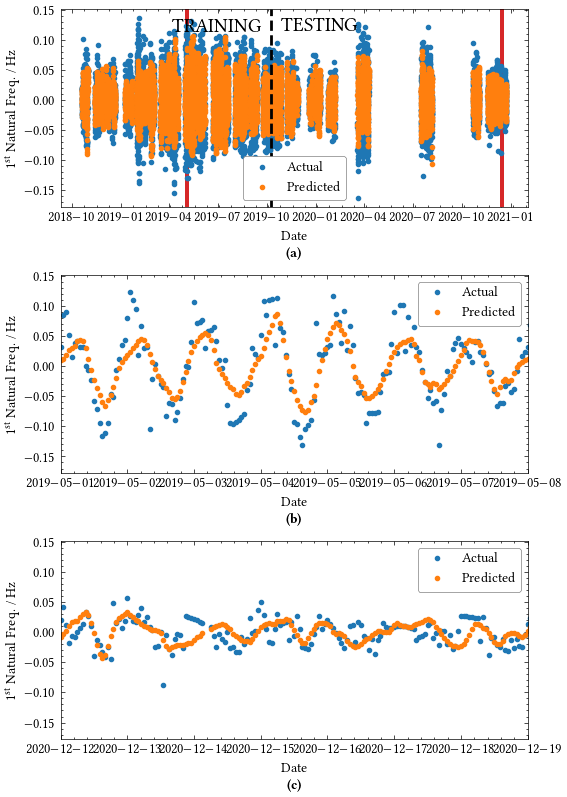

In [1007]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, 3.5*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=3)

axes = axes.ravel()

props = dict(ls='', marker='.')

for ax in axes:
    ax.plot(np.concatenate([train_df.index, test_df.index]), np.concatenate([endog, endog_test]),  **props, label='Actual')
    ax.plot(np.concatenate([train_df.index, test_df.index]), np.concatenate([train_preds, test_preds]),  **props, label='Predicted')
    
vl = axes[0].axvline(all_df.index.values[split_ind], ls='--', c='k', lw='2.0')
vl_x_ax = axes[0].transAxes.inverted().transform(axes[0].transData.transform(vl.get_xydata()[0]))[0]
axes[0].annotate('TRAINING',
        xy=(0.95*vl_x_ax, 0.95),
        xycoords='axes fraction',
        ha='right',
        va='top',
        fontsize=14.0,
        fontweight='bold')
axes[0].annotate('TESTING',
             xy=(1.05*vl_x_ax, 0.95),
             xycoords='axes fraction',
             ha='left',
             va='top',
             fontsize=14.0,
             fontweight='bold')

train_start = pd.to_datetime('2019-5-1')
train_end = pd.to_datetime('2019-5-8')

axes[0].axvspan(train_start, train_end, fc='C3')
axes[1].set_xlim([train_start, train_end])

test_start = pd.to_datetime('2020-12-12')
test_end = pd.to_datetime('2020-12-19')

axes[0].axvspan(test_start, test_end, fc='C3')
axes[2].set_xlim([test_start, test_end])

for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
    ax.legend()
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

# Fit ARIMAX

In [873]:
model  = sm.api.tsa.SARIMAX(endog,
                            exog, 
                            order=(2,1,1),
                            trend='c').fit()
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26406D+00    |proj g|=  3.91709D+00

At iterate    5    f= -2.26920D+00    |proj g|=  7.03726D-02


 This problem is unconstrained.



At iterate   10    f= -2.27039D+00    |proj g|=  8.48609D-01

At iterate   15    f= -2.27073D+00    |proj g|=  2.87449D-02

At iterate   20    f= -2.27075D+00    |proj g|=  1.67343D-01

At iterate   25    f= -2.27078D+00    |proj g|=  3.84893D-03

At iterate   30    f= -2.27078D+00    |proj g|=  3.32652D-02

At iterate   35    f= -2.27106D+00    |proj g|=  1.27698D+00

At iterate   40    f= -2.27892D+00    |proj g|=  3.43978D+00

At iterate   45    f= -2.28554D+00    |proj g|=  4.93065D+00

At iterate   50    f= -2.29612D+00    |proj g|=  4.89917D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5768
Model:               SARIMAX(2, 1, 1)   Log Likelihood               13243.996
Date:                Thu, 11 Aug 2022   AIC                         -26475.993
Time:                        00:16:16   BIC                         -26436.033
Sample:                             0   HQIC                        -26462.088
                               - 5768                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.544e-07   1.58e-05     -0.035      0.972   -3.15e-05    3.04e-05
x1            -0.0088      0.000    -25.697      0.000      -0.009      -0.008
ar.L1          0.5463      0.014     39.212      0.000       0.519       0.574
ar.L2          0.1881      0.013     14.400      0.000       0.162       0.214
ma.L1         -0.9551      0.008   -119.891      0.000      -0.971      -0.939
sigma2         0.0006   9.84e-06     65.380      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):               857.57
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.14
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

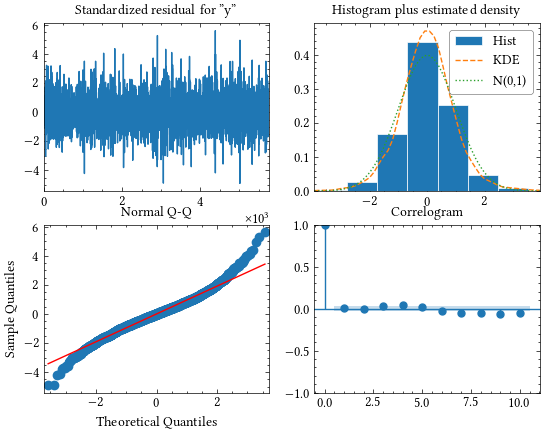

In [718]:
_ = model.plot_diagnostics()

In [719]:
exog_test = test_df.air_temperature.values.reshape(-1,1)
endog_test = test_df.freq.values

In [720]:
train_preds = model.forecast(steps=len(exog), exog=exog)
test_preds = model.forecast(steps=len(exog_test), exog=exog_test)

In [721]:
from sklearn.metrics import mean_squared_error
print("Train RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(endog, train_preds))))
print("Test RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(endog_test, test_preds))))

Train RMSE: 0.076 Hz
Test RMSE: 0.092 Hz


In [722]:
train_res = endog - train_preds
test_res = endog_test - test_preds 

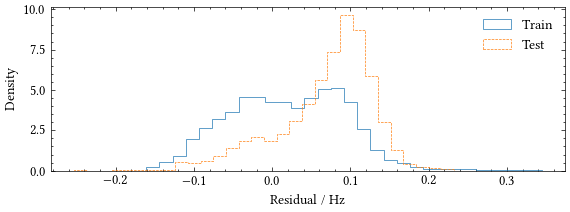

In [723]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

ax_props = dict(bins=30, density=True, histtype='step')

ax.hist(train_res, **ax_props, label='Train')
ax.hist(test_res, **ax_props, label='Test')

ax.set_xlabel(r'Air Temperature / \unit{\celsius}')
ax.set_xlabel(r'Residual / \unit{\hertz}')
ax.set_ylabel('Density')
ax.legend(edgecolor='None')
    
fig.tight_layout()

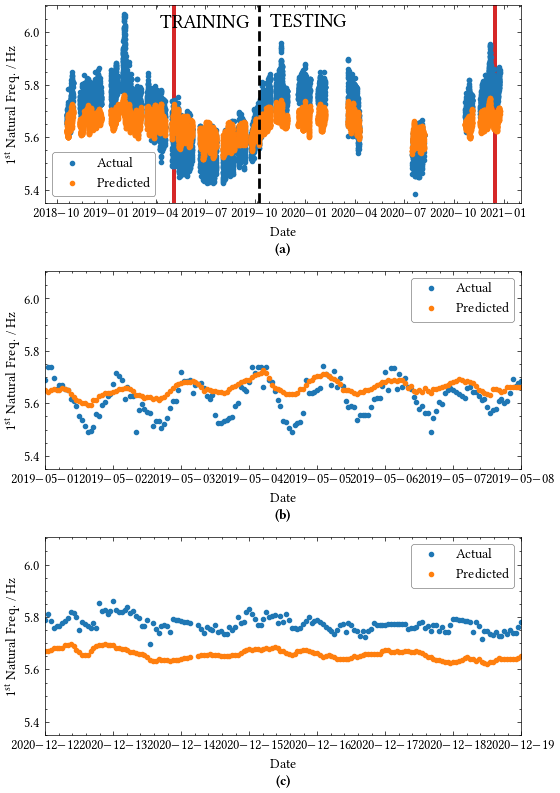

In [724]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, 3.5*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=3)

axes = axes.ravel()

props = dict(ls='', marker='.')

for ax in axes:
    ax.plot(np.concatenate([train_df.index, test_df.index]), np.concatenate([endog, endog_test]),  **props, label='Actual')
    ax.plot(np.concatenate([train_df.index, test_df.index]), np.concatenate([train_preds, test_preds]),  **props, label='Predicted')
    
vl = axes[0].axvline(all_df.index.values[split_ind], ls='--', c='k', lw='2.0')
vl_x_ax = axes[0].transAxes.inverted().transform(axes[0].transData.transform(vl.get_xydata()[0]))[0]
axes[0].annotate('TRAINING',
        xy=(0.95*vl_x_ax, 0.95),
        xycoords='axes fraction',
        ha='right',
        va='top',
        fontsize=14.0,
        fontweight='bold')
axes[0].annotate('TESTING',
             xy=(1.05*vl_x_ax, 0.95),
             xycoords='axes fraction',
             ha='left',
             va='top',
             fontsize=14.0,
             fontweight='bold')

train_start = pd.to_datetime('2019-5-1')
train_end = pd.to_datetime('2019-5-8')

axes[0].axvspan(train_start, train_end, fc='C3')
axes[1].set_xlim([train_start, train_end])

test_start = pd.to_datetime('2020-12-12')
test_end = pd.to_datetime('2020-12-19')

axes[0].axvspan(test_start, test_end, fc='C3')
axes[2].set_xlim([test_start, test_end])

for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
    ax.legend()
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

# Fit AR-X

In [850]:
endog = ydiff
exog = xdiff

# endog = y
# exog = x

exog_test = test_df.air_temperature.values.reshape(-1,1)
endog_test = test_df.freq.values

exog_test = sm.tsa.statespace.tools.diff(exog_test)
endog_test = sm.tsa.statespace.tools.diff(endog_test)

order = sm.tsa.ar_model.ar_select_order(endog=endog,
                                        exog=exog,
                                        maxlag=6,
                                        ic='bic',
                                        trend='c',
                                        glob=True,
                                        seasonal=False)

In [851]:
order.ar_lags

[1, 3, 4]

In [852]:
model  = sm.tsa.ar_model.AutoReg(endog=endog,
                                 exog=exog, 
                                 lags=order.ar_lags,
                                 trend='c').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                             
===============================================================================
Dep. Variable:                       y   No. Observations:                 5767
Model:             Restr. AutoReg-X(4)   Log Likelihood               12973.227
Method:                Conditional MLE   S.D. of innovations              0.025
Date:                 Thu, 11 Aug 2022   AIC                         -25934.455
Time:                         00:15:05   BIC                         -25894.500
Sample:                              4   HQIC                        -25920.551
                                  5767                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.641e-06      0.000     -0.020      0.984      -0.001       0.001
y.L1          -0.2552      0.013    -20.260      0.000      -0.280      -0.230
y.L3           0.0422      0.013      3.299      0.001       0.017       0.067
y.L4           0.0430      0.013      3.372      0.001       0.018       0.068
x1            -0.0079      0.000    -19.358      0.000      -0.009      -0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2462           -0.0000j            2.2462           -0.0000
AR.2           -0.5564           -2.1415j            2.2126           -0.2905
AR.3           -0.5564           +2.1415j            2.2126            0.2905
AR.4           -2.1140           -0.0000j            2.1140           -0.5000
-----------------------------------------------------------------------------
"""

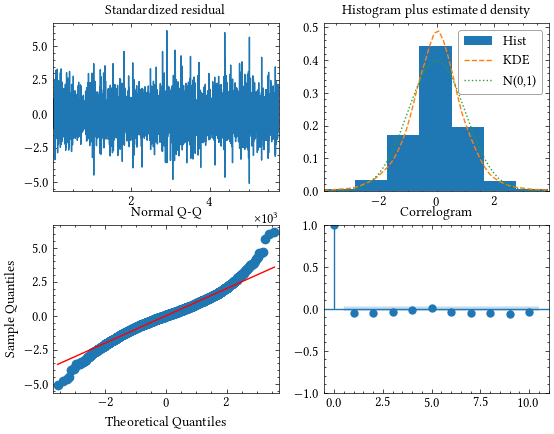

In [853]:
_ = model.plot_diagnostics()

In [854]:
train_preds = model.forecast(steps=len(exog), exog=exog)
test_preds = model.forecast(steps=len(exog_test), exog=exog_test)

In [855]:
from sklearn.metrics import mean_squared_error
print("Train RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(endog, train_preds))))
print("Test RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(endog_test, test_preds))))

Train RMSE: 0.027 Hz
Test RMSE: 0.025 Hz


In [856]:
train_res = endog - train_preds
test_res = endog_test - test_preds 

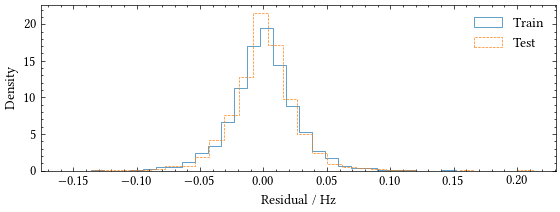

In [857]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

ax_props = dict(bins=30, density=True, histtype='step')

ax.hist(train_res, **ax_props, label='Train')
ax.hist(test_res, **ax_props, label='Test')

ax.set_xlabel(r'Air Temperature / \unit{\celsius}')
ax.set_xlabel(r'Residual / \unit{\hertz}')
ax.set_ylabel('Density')
ax.legend(edgecolor='None')
    
fig.tight_layout()

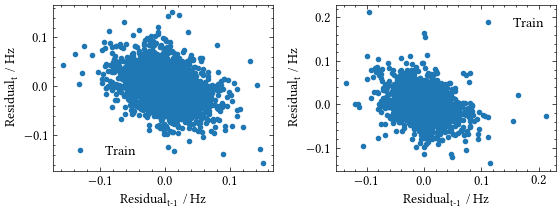

In [858]:
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=1, ncols=2)

ax_props = dict(ls='', marker='.')

axes[0].plot(train_res[:-1], train_res[1:], **ax_props, label='Train')
axes[1].plot(test_res[:-1], test_res[1:], **ax_props, label='Train')

for ax in axes:
    ax.set_xlabel(r'Residual\textsubscript{t-1} / \unit{\hertz}')
    ax.set_ylabel(r'Residual\textsubscript{t} / \unit{\hertz}')
    ax.legend(edgecolor='None')
    
fig.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (9614,) and (9612,)

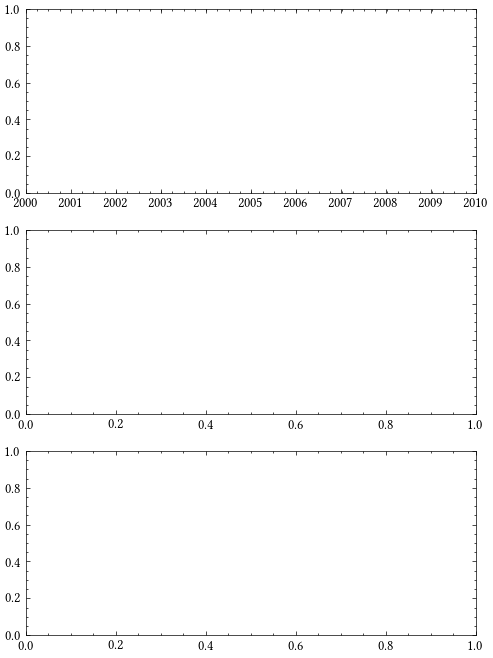

In [859]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, 3.5*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=3)

axes = axes.ravel()

props = dict(ls='', marker='.')

for ax in axes:
    ax.plot(np.concatenate([train_df.index, test_df.index]), np.concatenate([endog, endog_test]),  **props, label='Actual')
    ax.plot(np.concatenate([train_df.index, test_df.index]), np.concatenate([train_preds, test_preds]),  **props, label='Predicted')
    
vl = axes[0].axvline(all_df.index.values[split_ind], ls='--', c='k', lw='2.0')
vl_x_ax = axes[0].transAxes.inverted().transform(axes[0].transData.transform(vl.get_xydata()[0]))[0]
axes[0].annotate('TRAINING',
        xy=(0.95*vl_x_ax, 0.95),
        xycoords='axes fraction',
        ha='right',
        va='top',
        fontsize=14.0,
        fontweight='bold')
axes[0].annotate('TESTING',
             xy=(1.05*vl_x_ax, 0.95),
             xycoords='axes fraction',
             ha='left',
             va='top',
             fontsize=14.0,
             fontweight='bold')

train_start = pd.to_datetime('2019-5-1')
train_end = pd.to_datetime('2019-5-8')

axes[0].axvspan(train_start, train_end, fc='C3')
axes[1].set_xlim([train_start, train_end])

test_start = pd.to_datetime('2020-12-12')
test_end = pd.to_datetime('2020-12-19')

axes[0].axvspan(test_start, test_end, fc='C3')
axes[2].set_xlim([test_start, test_end])

for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
    ax.legend()
    
ajf_plts.caption_axes(axes)
fig.tight_layout()